<a href="https://colab.research.google.com/github/htdung167/CS406.M11/blob/main/Notebooks/HoughLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import argparse
import cv2 as cv
import imutils
from itertools import combinations
from sklearn.cluster import KMeans
from math import sin, cos, atan

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
class DocumentScannerBasedHoughLines:
  def __init__(self, image, output="type0", show_process = False,rho_acc = 1, theta_acc = 360, thresh = 100):
    self.img = image
    self.output = output
    self.show_process = show_process
    self.rho_acc = rho_acc
    self.theta_acc = theta_acc
    self.thresh = thresh

  def order_points(self, points):
    # print(points)
    rect = np.zeros((4,2), dtype = "float32")
    sum_ = points.sum(axis=1)
    rect[0] = points[np.argmin(sum_)]
    rect[2] = points[np.argmax(sum_)]
    diff_ = np.diff(points, axis=1)
    # print(diff_)
    rect[1] = points[np.argmin(diff_)]
    rect[3] = points[np.argmax(diff_)]
    # print(rect)
    return rect

  def transform_topdown(self, img, points):
    rect = self.order_points(points)
    tl, tr, br, bl = rect
    widthA = np.sqrt(((br[0]- bl[0])**2) +((br[1]- bl[1])**2))
    widthB = np.sqrt(((tl[0]- tr[0])**2) +((tl[1]- tr[1])**2))
    maxWidth = max(widthA, widthB)
    heightA = np.sqrt(((br[0]- tr[0])**2) +((br[1]- tr[1])**2))
    heightB = np.sqrt(((bl[0]- tl[0])**2) +((bl[1]- tl[1])**2))
    maxHeight = max(heightA, heightB)
    dst = np.array([
      [0, 0],
      [maxWidth - 1, 0],
      [maxWidth - 1, maxHeight - 1],
      [0, maxHeight - 1]], dtype = "float32")
    M = cv.getPerspectiveTransform(rect, dst)
    warped = cv.warpPerspective(img, M, (int(maxWidth), int(maxHeight)))
    # warped = cv.warpPerspective(img, M, (int(800), int(1000)))
    return warped

  def preprocess(self, blur_method="gaussian"):
    image = self.img.copy()
    self.ratio = image.shape[0] / 500.0
    self.img_resize = cv.resize(image, (int(image.shape[1] / self.ratio) ,500))
    img_gray = cv.cvtColor(self.img_resize, cv.COLOR_BGR2GRAY)
    img_blur = None
    if blur_method == "gaussian":
      img_blur = cv.GaussianBlur(img_gray, (3, 3), 0)
    elif blur_method == "bilateral":
      img_blur=cv.bilateralFilter(img_gray, 30, 20, 20)
    if self.show_process==True:
      cv2_imshow(self.img_resize)
      cv2_imshow(img_gray)
      cv2_imshow(img_blur)
    cv.imwrite('/content/gray.jpg', img_gray)
    cv.imwrite('/content/blur.jpg', img_blur)
    return img_blur


  def handle_edge(self):
    img_blur = self.preprocess(blur_method="gaussian")
    edged = cv.Canny(img_blur, 171, 247)
    kernel3 = np.ones((3,3), np.uint8)
    # img_close = cv.morphologyEx(edged, cv.MORPH_CLOSE, kernel3)
    if self.show_process==True:
      cv2_imshow(edged)
    cv.imwrite('/content/edged.jpg', edged)
    self.img_precess = edged
    lines = cv.HoughLines(edged, 1, np.pi / 360, 50)
    hough_line_output = edged.copy()
    
    # for line in lines:
    #     rho, theta = line[0]
    #     a, b = np.cos(theta), np.sin(theta)
    #     x0, y0 = a * rho, b * rho
    #     n = 5000
    #     x1 = int(x0 + n * (-b))
    #     y1 = int(y0 + n * (a))
    #     x2 = int(x0 - n * (-b))
    #     y2 = int(y0 - n * (a))
    #     cv.line(hough_line_output, (x1, y1), (x2, y2), (0, 0, 255), cv.LINE_AA)
    # cv2_imshow(hough_line_output)
    return edged


  def get_hough_lines(self):
    lines = cv.HoughLines(self.img_precess.copy(), self.rho_acc, np.pi / self.theta_acc, self.thresh)
    if self.show_process: 
      self.draw_hough_lines(lines)
    self._lines = lines
    return lines

  def draw_hough_lines(self, lines):
    hough_line_output = self.img_resize.copy()
    for line in lines:
        rho, theta = line[0]
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        n = 5000
        x1 = int(x0 + n * (-b))
        y1 = int(y0 + n * (a))
        x2 = int(x0 - n * (-b))
        y2 = int(y0 - n * (a))
        cv.line(hough_line_output, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2_imshow(hough_line_output)
    cv.imwrite('/content/hough_line_output.jpg', hough_line_output)
  def get_intersections(self):
    lines = self._lines
    intersections = []
    group_lines = combinations(range(len(lines)), 2)
    x_in_range = lambda x: 0 <= x <= self.img_precess.shape[1]
    y_in_range = lambda y: 0 <= y <= self.img_precess.shape[0]

    for i, j in group_lines:
      line_i, line_j = lines[i][0], lines[j][0]
      
      if 60.0 < self._get_angle_between_lines(line_i, line_j) < 100.0:
        int_point = self._intersection(line_i, line_j)
        if x_in_range(int_point[0][0]) and y_in_range(int_point[0][1]): 
          intersections.append(int_point)
    if self.show_process: 
      self.draw_intersections(intersections)
    
    self._intersections = intersections
    return intersections

  def _intersection(self, line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([[np.cos(theta1), np.sin(theta1)],[np.cos(theta2), np.sin(theta2)]])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [[x0, y0]]

  def _get_angle_between_lines(self, line_1, line_2):
        rho1, theta1 = line_1
        rho2, theta2 = line_2
        # x * cos(theta) + y * sin(theta) = rho
        # y * sin(theta) = x * (- cos(theta)) + rho
        # y = x * (-cos(theta) / sin(theta)) + rho
        m1 = -(np.cos(theta1) / np.sin(theta1))
        m2 = -(np.cos(theta2) / np.sin(theta2))
        return abs(atan(abs(m2-m1) / (1 + m2 * m1))) * (180 / np.pi)

  def draw_intersections(self, intersections):
    intersection_point_output = self.img_resize.copy()
    for line in self._lines:
      rho, theta = line[0]
      a = np.cos(theta)
      b = np.sin(theta)
      x0 = a * rho
      y0 = b * rho
      n = 5000
      x1 = int(x0 + n * (-b))
      y1 = int(y0 + n * (a))
      x2 = int(x0 - n * (-b))
      y2 = int(y0 - n * (a))
      cv.line(intersection_point_output, (x1, y1), (x2, y2), (0, 0, 255), 2)

    for point in intersections:
      x, y = point[0]
      cv.circle(intersection_point_output,(x, y),5,(255, 255, 127),5)
    cv2_imshow(intersection_point_output)
    cv.imwrite('/content/intersection_point_output.jpg', intersection_point_output)

  def calculate_area(self, points):
    area4 = 0
    fourpoints = self.order_points(points.copy())
    def dientichtamgiac(threepoints):
        A, B, C = threepoints
        area3 = 1/2 * np.abs(((B[0] - A[0])*(C[1] - A[1]) - (C[0] - A[0])*(B[1] - A[1])))
        return area3
    area4 = dientichtamgiac([points[0],points[1], points[2]]) + dientichtamgiac([points[2],points[3], points[0]])
    return area4

  def find_quadrilaterals(self):
    X = (np.array([[point[0][0], point[0][1]] for point in self._intersections]))
    kmeans = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0).fit(X)
    if self.show_process: 
      self.draw_quadrilaterals(self._lines, kmeans)
    self.screenCnt = None
    fourpoints = np.array([[center.tolist()] for center in kmeans.cluster_centers_])
    min_area = self.img_resize.shape[0] * self.img_resize.shape[1] // 5
    if self.calculate_area(fourpoints.reshape(4, 2)) > min_area:
        self.screenCnt = fourpoints
        self.screenCnt = (self.screenCnt*self.ratio).astype("int32")
    return self.screenCnt
  
  def draw_quadrilaterals(self, lines, kmeans):
    # print(self.screenCnt)
    grouped_output = self.img_resize.copy()
    for line in lines:
      rho, theta = line[0]
      a, b = np.cos(theta), np.sin(theta)
      x0, y0 = a * rho, b * rho
      n = 5000
      x1 = int(x0 + n * (-b))
      y1 = int(y0 + n * (a))
      x2 = int(x0 - n * (-b))
      y2 = int(y0 - n * (a))
      cv.line(grouped_output, (x1, y1), (x2, y2), (0, 0, 255), 2)
    for point in kmeans.cluster_centers_:
      x, y = point
      cv.circle(grouped_output,(int(x), int(y)),5,(255, 255, 255),5)
    cv2_imshow(grouped_output)
    cv.imwrite('/content/grouped.jpg', grouped_output)
  def get_result(self):
    self.handle_edge()
    self.get_hough_lines()
    self.get_intersections()
    self.find_quadrilaterals()

    warped = self.transform_topdown(self.img, self.screenCnt.reshape(4, 2))
    if self.output == "type0":
      pass
    elif self.output == "type1":
      warped = cv.GaussianBlur(warped, (3,3), 0)
    elif self.output == "type2":
      warped = cv.cvtColor(warped, cv.COLOR_BGR2GRAY)
      warped = cv.adaptiveThreshold(warped, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 31, 10)

    self.result = warped
    if self.show_process == True:
      cv2_imshow(self.result)
    return self.img, self.result

  def show_result(self, smaller=100):
    origin, result = self.get_result()
    origin = cv.resize(origin, (int(origin.shape[1]*smaller/ 100), int(origin.shape[0]*smaller/ 100)))
    result = cv.resize(result, (origin.shape[1],origin.shape[0]))
    cv.imwrite('/content/result.jpg', result)
    cv2_imshow(origin)
    cv2_imshow(result)



In [ ]:
path = "/content/drive/MyDrive/CS406 Nhóm/sample_imgs/cell_pic.jpg"
img = cv.imread(path)
scan = DocumentScannerBasedHoughLines(img, "type2", True)
# scan.show_result(50)

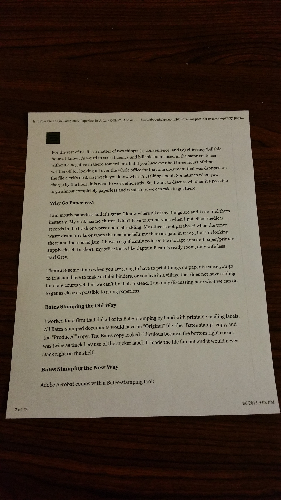

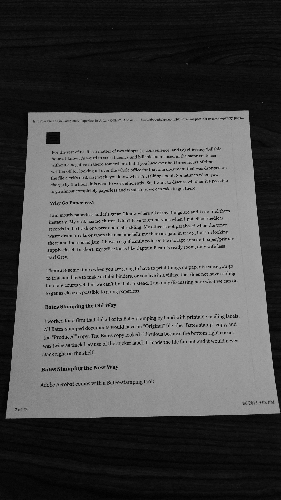

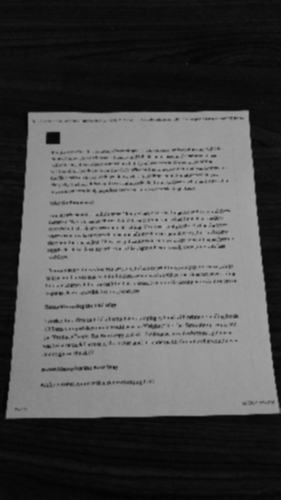

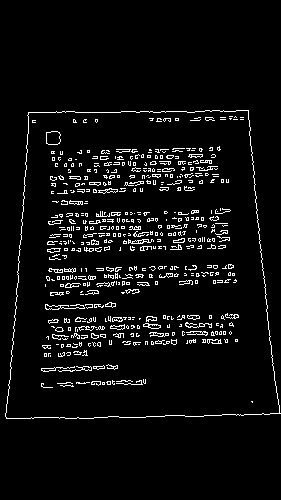

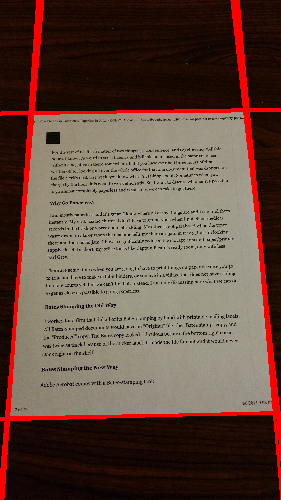

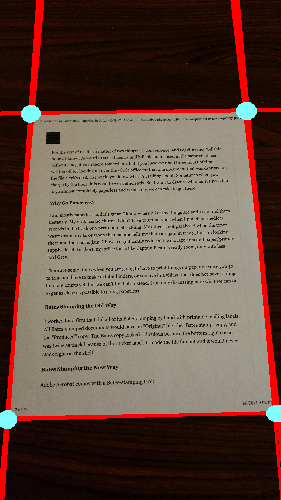

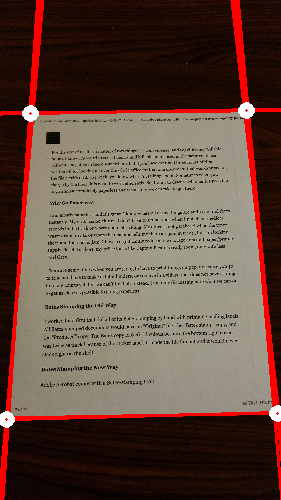

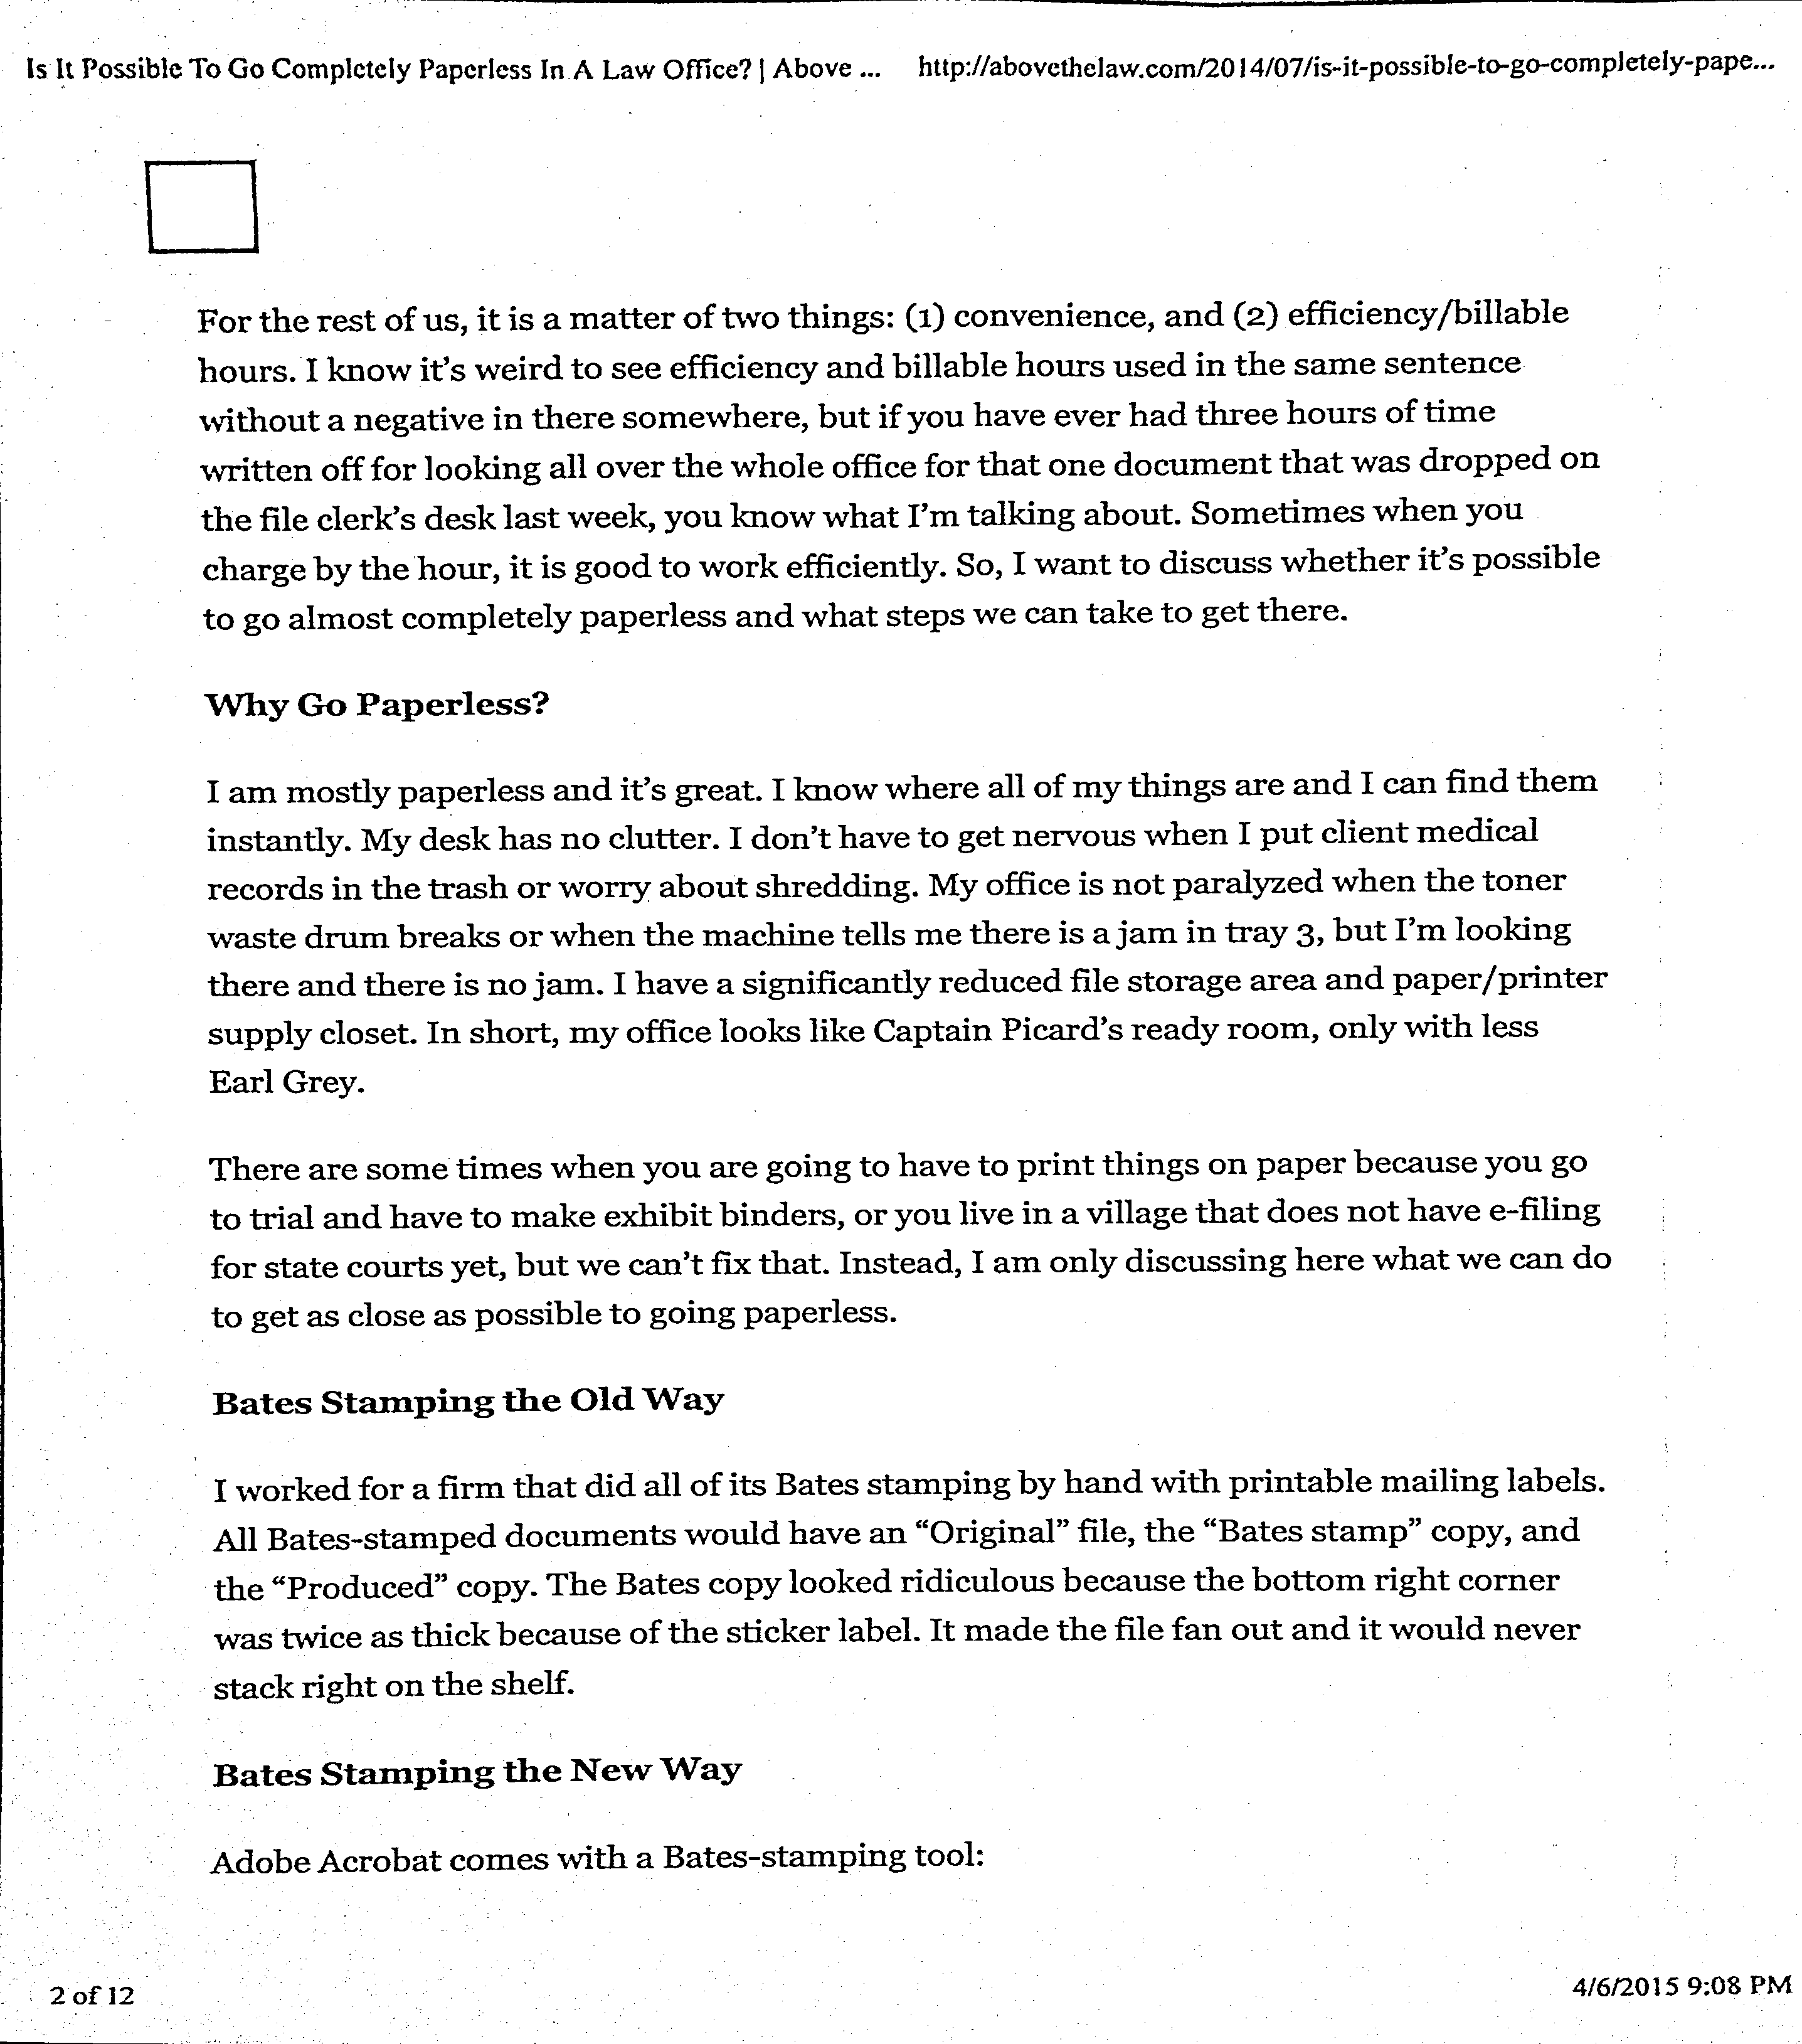

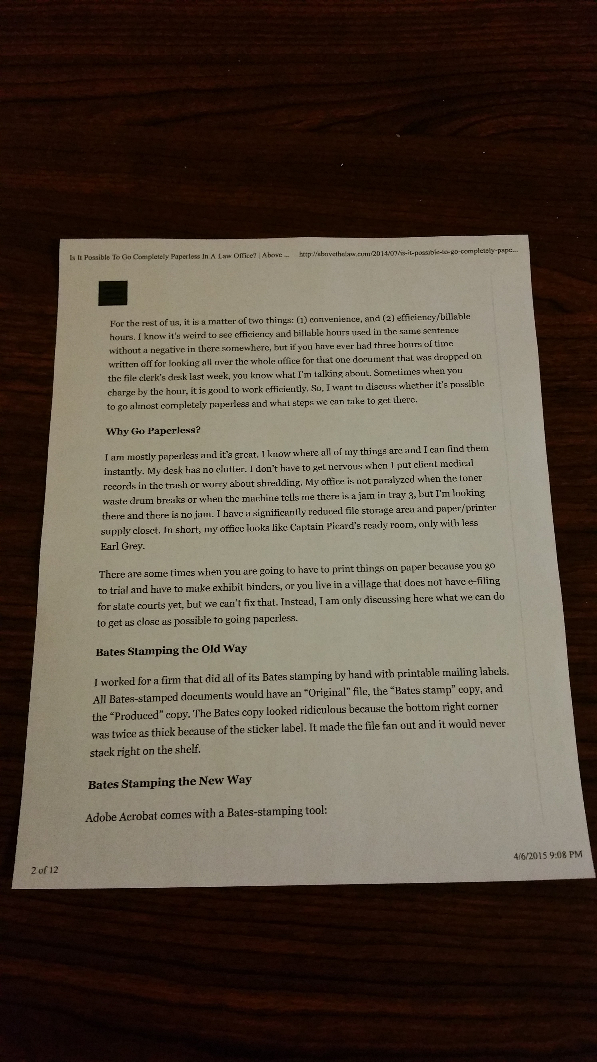

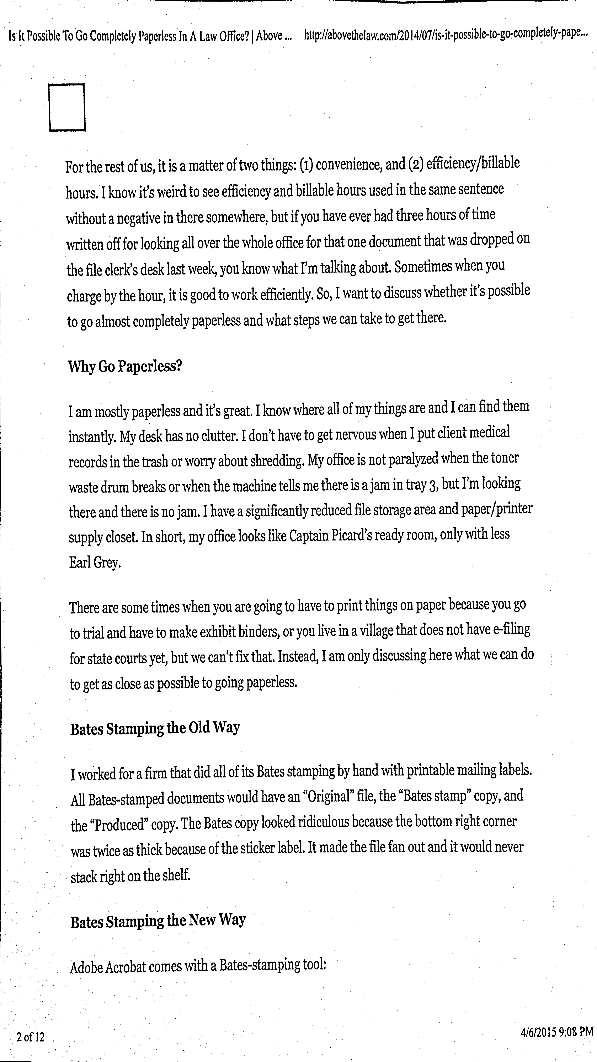

In [ ]:
scan.show_result(20)

In [ ]:
img = cv.imread("/content/drive/MyDrive/CS406 Nhóm/sample_imgs/test1.png")
ratio = img.shape[0] / 500.0
img_resize = cv.resize(img, (int(img.shape[1] / ratio) ,500))
img_resize = cv.cvtColor(img_resize, cv.COLOR_BGR2GRAY)
cv2_imshow(img_resize)

In [ ]:
temp = cv.fastNlMeansDenoising(img_resize, h = 7)
cv2_imshow(temp)

In [ ]:
img_blur = cv.GaussianBlur(img_resize, (3, 3), 0)
cv2_imshow(img_blur)

In [ ]:
T_, thresholded = cv.threshold(temp, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
cv2_imshow(thresholded)

In [ ]:
edged = cv.Canny(thresholded, 60, 200)
kernel3 = np.ones((3,3), np.uint8)
# img_close = cv.morphologyEx(edged, cv.MORPH_CLOSE, kernel3)
cv2_imshow(edged)

In [ ]:
edged = cv.Canny(img_blur, 60, 200)
kernel3 = np.ones((3,3), np.uint8)
img_close = cv.morphologyEx(edged, cv.MORPH_CLOSE, kernel3)
cv2_imshow(edged)

In [ ]:
import math

In [ ]:
lines = cv.HoughLines(edged, rho=1, theta=np.pi/360, threshold=90)
ouput = img_resize.copy()
for i in range(0, len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv.line(ouput, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
cv2_imshow(ouput)

In [ ]:
lines = cv.HoughLines(img_close, rho=1, theta=np.pi/360, threshold=100)
ouput = img_resize.copy()
for i in range(0, len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv.line(ouput, pt1, pt2, (0,0,255), 3, cv.LINE_AA)
cv2_imshow(ouput)